<a href="https://colab.research.google.com/github/stellaevat/ontology-mapping/blob/main/colabs/dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pronto \
&& wget -O doid.obo https://gla-my.sharepoint.com/:u:/g/personal/2526934t_student_gla_ac_uk/EfUC_RdrfZdOsOrtmNATjuoBPDaIkSTUMyxJXyO2KKC6yw?download=1 \
&& wget -O ncit.obo https://gla-my.sharepoint.com/:u:/g/personal/2526934t_student_gla_ac_uk/ETmaJIC0fAlItdsp8WQxS_wBzKN_6x08EZrtsOxVnbzvSg?download=1

In [ ]:
import pronto
import editdistance
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

# Load ontologies

In [ ]:
ncit = pronto.Ontology("ncit.obo")
print(ncit.__len__())

doid = pronto.Ontology("doid.obo")
print(doid.__len__())

# Read/Write to file

In [ ]:
def write_mappings(mappings, filepath):
  with open(filepath, "w") as f:
    for (source_id, target_id) in mappings.items():
      if isinstance(target_id, str):
        f.write(f"{source_id},{target_id}\n")
      else:
        for id in target_id:
          f.write(f"{source_id},{id}\n")

def read_mappings(filepath):
  mappings = {}
  with open(filepath) as f:
    for line in f:
      source_id, target_id = line.strip().split(',')
      mappings[source_id] = target_id
  return mappings

In [ ]:
def write_bi_encoder_sentences(sentences, filepath):
  source_sentences, target_sentences, labels = sentences
  with open(filepath, "w") as f:
    for (source_sentence, target_sentence, label) in zip(source_sentences, target_sentences, labels):
      f.write(f'"{source_sentence}","{target_sentence}","{label}"\n')

def write_cross_encoder_sentences(sentences, filepath):
  sentences, labels = sentences
  with open(filepath, "w") as f:
    for (sentence, label) in zip(sentences, labels):
      f.write(f'"{sentence}","{label}"\n')

def write_ontology_sentences(sentences, filepath):
  with open(filepath, "w") as f:
    for sentence in sentences:
      f.write(f'"{sentence}"\n')

# Extract equivalences

In [ ]:
def correct_id(id, corrections=[("NCI:", "NCIT:C"), ("NCIT:CC", "NCIT:C")]):
  for (before, after) in corrections:
    id = id.replace(before, after)
  return id

def get_entity_equivalences(source_onto, target_onto, target_code="NCIT:"):
  all_equivalences = {}

  for term in source_onto.terms():
    xref_ids = [correct_id(xref.id) for xref in term.xrefs]
    xref_ids = [id for id in xref_ids if target_code in id and id in target_onto.terms()]
    if len(xref_ids) == 1:
      all_equivalences[correct_id(term.id)] = correct_id(xref_ids[0])

  return all_equivalences

In [ ]:
equiv_doid2ncit = get_entity_equivalences(doid, ncit)
equiv_ncit2doid = {v:k for (k,v) in equiv_doid2ncit.items()}
print("Total equivalences: ", len(equiv_doid2ncit))

Total equivalences:  4331


In [ ]:
write_mappings(equiv_ncit2doid, "equiv_ncit2doid.csv")

# Derive subsumptions

In [ ]:
def get_one_hop_neighbours(term, max_neighbours=3):
  parents = list(term.superclasses(distance=1, with_self=False))
  children = list(term.subclasses(distance=1, with_self=False))
  neighbours = parents + children

  total_neighbours = len(neighbours)
  if total_neighbours > max_neighbours:
    neighbours = np.random.choice(
        neighbours,
        size=max_neighbours,
        replace=False
    )
  return neighbours, total_neighbours


def get_random_targets(subsumptions, max_targets=3):
  target_ids = set(subsumptions.values())
  target_counts = {}
  total_count = 0
  for target_id in subsumptions.values():
    target_counts[target_id] = target_counts.get(target_id, 0) + max_targets
    total_count += max_targets

  neg_subsumptions = {}
  for (source_id, target_id) in tqdm(subsumptions.items()):
    choice = list(target_ids - {target_id})
    # Probability of choosing target proportional to how many times it can be used
    probabilities = [target_counts[id] / (total_count - target_counts[target_id]) for id in choice]

    neg_target_ids = choice if len(choice) <= max_targets else np.random.choice(choice, size=max_targets, replace=False, p=probabilities)
    neg_subsumptions[source_id] = neg_target_ids

    for id in neg_target_ids:
      target_counts[id] -= 1
      if target_counts[id] <= 0:
        target_ids.remove(id)

    total_count -= max_targets
  return neg_subsumptions


def get_subsumptions_from_equivalences(equivalences, target_onto, negative=False):
  assert negative in [False, 'random', 'multi', 'neighbour'], "Negative sampling method must be 'random', 'multi' or 'neighbour'."

  np.random.seed(3)
  subsumptions = {}
  target_parent_counts = []
  target_parent_neighbour_counts = []
  target_ids = list(equivalences.values())

  for (source_id, target_id) in tqdm(equivalences.items()):
    if target_id in target_onto.terms():
      target_entity = target_onto.get_term(target_id)
      target_parents = set(target_entity.superclasses(distance=1, with_self=False))
      target_parent_counts.append(len(target_parents))

      # Only keep targets with single parents
      if len(target_parents) == 1:
        target_parent = target_parents.pop()
        if negative == 'neighbour':
          target_parent_neighbours, total_neighbours = get_one_hop_neighbours(target_parent, max_neighbours=3)
          target_parent_neighbour_counts.append(total_neighbours)
          subsumptions[source_id] = [target.id for target in target_parent_neighbours]
        else:
          subsumptions[source_id] = target_parent.id

  if negative == 'random':
    subsumptions = get_random_targets(subsumptions, max_targets=1)
  elif negative == 'multi':
    subsumptions = get_random_targets(subsumptions, max_targets=3)

  print()
  print("Target parent counts: ", Counter(target_parent_counts))
  if negative == 'neighbour':
    print("Target parent neighbour counts: ", Counter(target_parent_neighbour_counts))
  return subsumptions

In [ ]:
all_neg_subsumptions = {}
direction = "ncit2doid"
negative_sampling = ["random", "multi", "neighbour"]

subs_ncit2doid = get_subsumptions_from_equivalences(equiv_ncit2doid, doid)
write_mappings(subs_ncit2doid, "subs_ncit2doid.csv")
print(f"Total subsumptions ({direction}): ", len(subs_ncit2doid))

for negative in negative_sampling:
  neg_subsumptions = get_subsumptions_from_equivalences(equiv_ncit2doid, doid, negative=negative)
  all_neg_subsumptions[negative] = subsumptions

  write_mappings(neg_subsumptions, f"neg_{negative}_{direction}.csv")
  print(f"Total ({negative}) negative subsumptions ({direction}): ", len(neg_subsumptions))

# Generate sentences

In [ ]:
def get_sentence(term_id, term_onto, features, max_neighbours=3):
  assert features in ['term', 'internal', 'parents', 'children'], "Features included must be 'term', 'internal', 'parents' or 'children'."

  sep = '[SEP]'
  term = term_onto.get_term(term_id)
  sentence = [term.name]

  if features == 'internal':
    definition = [term.definition] if term.definition else []
    sentence += definition
  elif features == 'parents':
    parents = list(term.superclasses(distance=1, with_self=False))
    if len(parents) > max_neighbours:
      parents = np.random.choice(
          parents,
          size=max_neighbours,
          replace=False
      )
    sentence += [parent.name for parent in parents]
  elif features == 'children':
    children = list(term.subclasses(distance=1, with_self=False))
    if len(children) > max_neighbours:
      children = np.random.choice(
          children,
          size=max_neighbours,
          replace=False
      )
    sentence += [child.name for child in children]

  sentence = sep.join(sentence)
  sentence = sentence.replace("\n", " ")
  return sentence


def get_labelled_sentences(subs, neg_subs, source_onto, target_onto, architecture, features=None):
  assert architecture in ['bi', 'cross'], "Architecture must either be 'bi' for bi-encoder or 'cross' for cross-encoder."
  assert features in ['term', 'internal', 'external'], "Features included must be 'term', 'internal' or 'external'."
  source_features, target_features = ('parents', 'children') if features == 'external' else (features, features)

  np.random.seed(3)
  cross_separator = '[SEP][CLS]'
  cross_sentences = []
  bi_source_sentences = []
  bi_target_sentences = []
  labels = []

  pairs = list(subs.items())
  if isinstance(list(neg_subs.values())[0], str):
    neg_pairs = list(neg_subs.items())
  else:
    neg_pairs = [(source_id, target_id) for (source_id, target_ids) in neg_subs.items() for target_id in target_ids]

  ones_and_zeros = [1] * len(pairs) + [0] * len(neg_pairs)
  labelled_pairs = list(zip(ones_and_zeros, pairs + neg_pairs))
  np.random.shuffle(labelled_pairs)

  for label, (source_id, target_id) in tqdm(labelled_pairs):
    if source_id not in source_onto.terms() or target_id not in target_onto.terms():
      continue

    source_sentence = get_sentence(source_id, source_onto, source_features)
    target_sentence = get_sentence(target_id, target_onto, target_features)
    if source_sentence and target_sentence:
      labels.append(label)
      if architecture == 'bi':
        bi_source_sentences.append(source_sentence)
        bi_target_sentences.append(target_sentence)
      elif architecture == 'cross':
        cross_sentences.append(cross_separator.join([source_sentence, target_sentence]))

  print()
  return (bi_source_sentences, bi_target_sentences, labels) if architecture == 'bi' else (cross_sentences, labels)

## Bi-encoder

In [ ]:
negative_sampling = ["random", "multi", "neighbour"]
features = ["term", "internal", "external"]
direction = "ncit2doid"

for negative in negative_sampling:
  neg_subsumptions = all_neg_subsumptions[negative]
  for feature in features:
    bi_sentences = get_labelled_sentences(subs_ncit2doid, neg_subsumptions, ncit, doid, architecture='bi', features=feature)
    write_bi_encoder_sentences(bi_sentences, f"bi_sentences_{feature}_{negative}_{direction}.csv")

    print(f"Total ({feature}) sentences ({direction}, {negative} neg. sampling): ", len(bi_sentences[0]))

## Cross-encoder

In [ ]:
negative_sampling = ["random", "multi", "neighbour"]
features = ["term", "internal", "external"]
direction = "ncit2doid"

for negative in negative_sampling:
  neg_subsumptions = all_neg_subsumptions[negative]
  for feature in features:
    cross_sentences = get_labelled_sentences(subs_ncit2doid, neg_subsumptions, ncit, doid, architecture='cross', features=feature)
    write_cross_encoder_sentences(cross_sentences, f"cross_sentences_{feature}_{negative}_{direction}.csv")

    print(f"Total cross-encoder ({feature}) sentences ({direction}, {negative} neg. sampling): ", len(cross_sentences[0]))

## Ontology

In [ ]:
doid_sentences_term, doid_sentences_int, doid_sentences_ext = [], [], []
for term in doid.terms():
  doid_sentences_term.append(get_sentence(term.id, doid, features=None))
  doid_sentences_int.append(get_sentence(term.id, doid, features='internal'))
  doid_sentences_ext.append(get_sentence(term.id, doid, features='children'))
print("Total DOID sentences (per setting): ", len(doid_sentences_term))

In [ ]:
write_ontology_sentences(doid_sentences_term, "doid_sentences_term.csv")
write_ontology_sentences(doid_sentences_int, "doid_sentences_int.csv")
write_ontology_sentences(doid_sentences_ext, "doid_sentences_ext.csv")

# String difference

## Equivalences

In [ ]:
str_equivalences = {ncit.get_term(source).name.lower() : doid.get_term(target).name.lower() for (source, target) in equiv_ncit2doid.items() if source in ncit.terms() and target in doid.terms()}

distances = np.array([editdistance.eval(source, target) for (source, target) in str_equivalences.items()])
lengths = np.array([max(len(source), len(target)) for (source, target) in str_equivalences.items()])
normalised = np.round(distances / lengths, decimals=2)

dist_distribution = Counter(distances)
norm_distribution = Counter(normalised)

Distances: [(0, 2374), (1, 94), (2, 126), (3, 50), (4, 114), (5, 82), (6, 66), (7, 93), (8, 139), (9, 72), (10, 74), (11, 66), (12, 41), (13, 59), (14, 61), (15, 70), (16, 75), (17, 51), (18, 82), (19, 40), (20, 51), (21, 36), (22, 33), (23, 42), (24, 30), (25, 34), (26, 24), (27, 20), (28, 11), (29, 22), (30, 7), (31, 11), (32, 10), (33, 19), (34, 19), (35, 14), (36, 6), (37, 8), (38, 4), (39, 5), (40, 9), (41, 2), (42, 7), (43, 3), (44, 5), (45, 4), (46, 5), (47, 3), (48, 2), (49, 1), (50, 6), (51, 1), (52, 1), (53, 2), (54, 1), (55, 4), (58, 2), (59, 1), (82, 1), (95, 1)]
Median: 0.0, Mean: 6.21, STD: 10.00


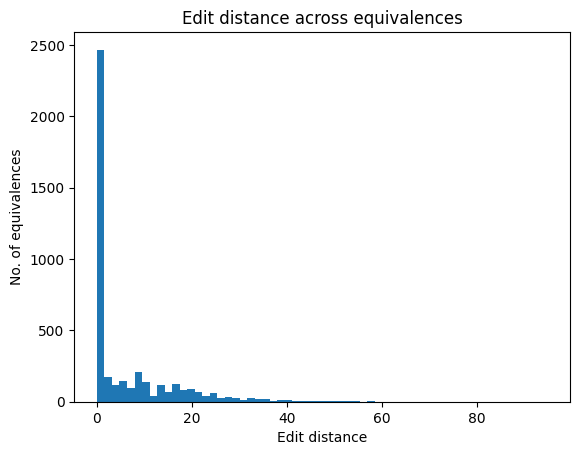

In [ ]:
plt.hist(distances, bins=len(dist_distribution))
plt.xlabel("Edit distance")
plt.ylabel("No. of equivalences")
plt.title("Edit distance across equivalences")
print("Distances:", sorted(dist_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(distances)}, Mean: {np.mean(distances):.2f}, STD: {np.std(distances):.2f}")

Text(0.5, 1.0, 'Edit distance across equivalences (0s excluded)')

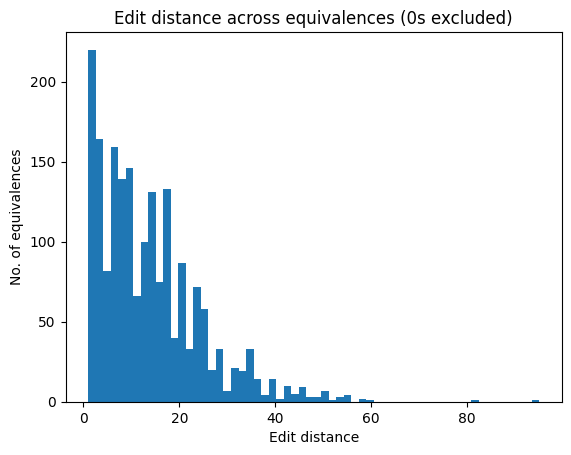

In [ ]:
plt.hist(distances[distances != 0], bins=len(dist_distribution))
plt.xlabel("Edit distance")
plt.ylabel("No. of equivalences")
plt.title("Edit distance across equivalences (0s excluded)")

Normalised: [(0.0, 2374), (0.01, 1), (0.02, 10), (0.03, 31), (0.04, 23), (0.05, 21), (0.06, 19), (0.07, 31), (0.08, 24), (0.09, 20), (0.1, 20), (0.11, 17), (0.12, 28), (0.13, 9), (0.14, 32), (0.15, 24), (0.16, 28), (0.17, 33), (0.18, 20), (0.19, 27), (0.2, 24), (0.21, 31), (0.22, 20), (0.23, 30), (0.24, 36), (0.25, 28), (0.26, 17), (0.27, 39), (0.28, 27), (0.29, 35), (0.3, 22), (0.31, 30), (0.32, 36), (0.33, 42), (0.34, 9), (0.35, 28), (0.36, 28), (0.37, 15), (0.38, 39), (0.39, 17), (0.4, 26), (0.41, 22), (0.42, 25), (0.43, 28), (0.44, 25), (0.45, 13), (0.46, 19), (0.47, 25), (0.48, 22), (0.49, 8), (0.5, 30), (0.51, 10), (0.52, 28), (0.53, 22), (0.54, 14), (0.55, 20), (0.56, 25), (0.57, 26), (0.58, 22), (0.59, 22), (0.6, 20), (0.61, 17), (0.62, 26), (0.63, 14), (0.64, 17), (0.65, 13), (0.66, 13), (0.67, 17), (0.68, 23), (0.69, 11), (0.7, 16), (0.71, 14), (0.72, 15), (0.73, 14), (0.74, 14), (0.75, 16), (0.76, 15), (0.77, 22), (0.78, 12), (0.79, 31), (0.8, 19), (0.81, 22), (0.82, 18), (0

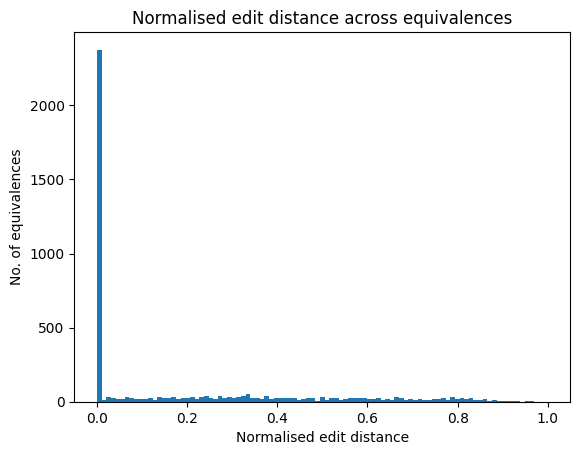

In [ ]:
plt.hist(normalised, bins=len(norm_distribution))
plt.xlabel("Normalised edit distance")
plt.ylabel("No. of equivalences")
plt.title("Normalised edit distance across equivalences")
print("Normalised:", sorted(norm_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(normalised)}, Mean: {np.mean(normalised):.2f}, STD: {np.std(normalised):.2f}")

Text(0.5, 1.0, 'Normalised edit distance across equivalences (0s excluded)')

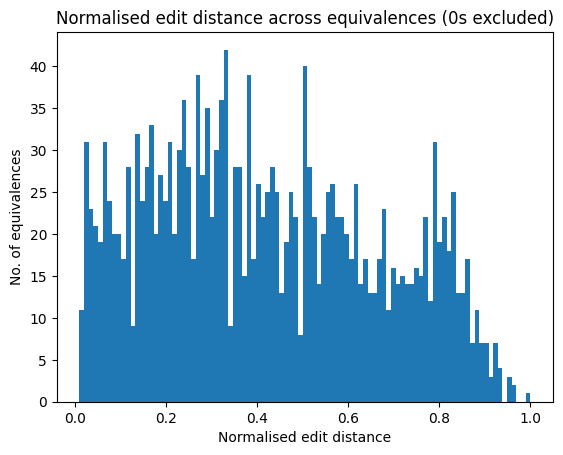

In [ ]:
plt.hist(normalised[normalised != 0], bins=len(norm_distribution))
plt.xlabel("Normalised edit distance")
plt.ylabel("No. of equivalences")
plt.title("Normalised edit distance across equivalences (0s excluded)")

{'whiskers': [<matplotlib.lines.Line2D at 0x7da6bde2e6b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7da6bde2ebf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7da6bde2e410>],
 'medians': [<matplotlib.lines.Line2D at 0x7da6bde2f130>],
 'fliers': [<matplotlib.lines.Line2D at 0x7da6bde2f3d0>],
 'means': []}

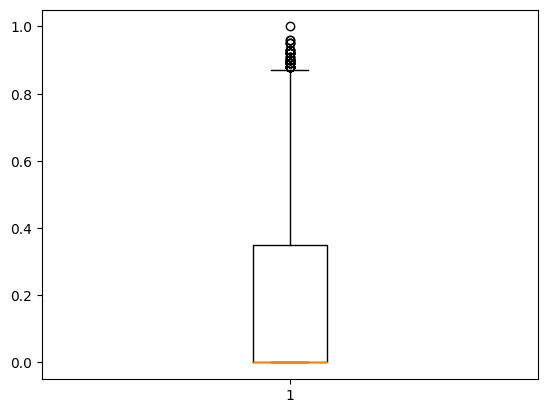

In [ ]:
plt.boxplot(normalised)

In [ ]:
print("Equivalences with distinct terms:\n")

count = 0
for (source, target) in str_equivalences.items():
  if editdistance.eval(source, target) / max(len(source), len(target)) > 0:
    count += 1
    if count % 100 == 0:
      print(f"{source} -> {target}")

print(f"\n{count} out of {len(str_equivalences)} ({(100 * count/len(str_equivalences)):.1f}%) are distinct")

Equivalences with distinct terms:

meningothelial cell neoplasm -> supratentorial meningioma
usher syndrome type 3 -> retinitis pigmentosa-deafness syndrome
acute respiratory failure -> respiratory failure
erectile dysfunction -> impotence
malignant nasolacrimal duct neoplasm -> lacrimal duct cancer
malignant tenosynovial giant cell tumor -> malignant giant cell tumor of the tendon sheath
lacrimal system disorder -> lacrimal apparatus disease
penile paget disease -> penis paget's disease
alcohol abuse -> alcohol use disorder
childhood mediastinal neurogenic neoplasm -> childhood mediastinal neurogenic tumor
malignant apocrine neoplasm -> apocrine sweat gland cancer
urethral clear cell adenocarcinoma -> urethra clear cell adenocarcinoma
bone paget disease -> paget's disease of bone
ovarian teratoma -> ovarian germ cell teratoma
hereditary glomangioma -> familial glomangioma
childhood ovarian choriocarcinoma -> childhood choriocarcinoma of the ovary
metastatic corticotroph pituitary neur

## Subsumptions

In [ ]:
str_subsumptions = {ncit.get_term(source).name.lower() : doid.get_term(target).name.lower() for (source, target) in subs_ncit2doid.items() if source in ncit.terms() and target in doid.terms()}

sub_distances = np.array([editdistance.eval(source, target) for (source, target) in str_subsumptions.items()])
sub_lengths = np.array([max(len(source), len(target)) for (source, target) in str_subsumptions.items()])
sub_normalised = np.round(sub_distances / sub_lengths, decimals=2)

sub_dist_distribution = Counter(sub_distances)
sub_norm_distribution = Counter(sub_normalised)

Distances: [(0, 5), (1, 3), (2, 2), (3, 7), (4, 47), (5, 58), (6, 108), (7, 148), (8, 138), (9, 173), (10, 215), (11, 184), (12, 171), (13, 166), (14, 142), (15, 147), (16, 129), (17, 131), (18, 119), (19, 107), (20, 120), (21, 110), (22, 98), (23, 76), (24, 76), (25, 53), (26, 71), (27, 42), (28, 51), (29, 37), (30, 35), (31, 32), (32, 24), (33, 26), (34, 25), (35, 17), (36, 13), (37, 15), (38, 15), (39, 15), (40, 4), (41, 6), (42, 8), (43, 3), (44, 5), (45, 2), (46, 1), (47, 5), (48, 4), (49, 2), (50, 3), (52, 2), (53, 4), (54, 3), (55, 1), (56, 3), (57, 3), (58, 1), (61, 3), (62, 1), (63, 1), (75, 1)]
Median: 15.0, Mean: 16.68, STD: 9.07


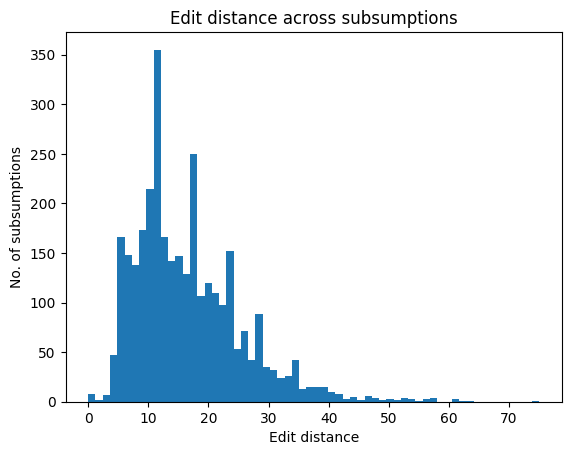

In [ ]:
plt.hist(sub_distances, bins=len(sub_dist_distribution))
plt.xlabel("Edit distance")
plt.ylabel("No. of subsumptions")
plt.title("Edit distance across subsumptions")
print("Distances:", sorted(sub_dist_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(sub_distances)}, Mean: {np.mean(sub_distances):.2f}, STD: {np.std(sub_distances):.2f}")

Normalised: [(0.0, 5), (0.06, 1), (0.07, 3), (0.09, 2), (0.1, 1), (0.11, 3), (0.12, 4), (0.13, 2), (0.14, 6), (0.15, 3), (0.16, 4), (0.17, 8), (0.18, 10), (0.19, 5), (0.2, 9), (0.21, 13), (0.22, 18), (0.23, 13), (0.24, 27), (0.25, 21), (0.26, 33), (0.27, 26), (0.28, 20), (0.29, 43), (0.3, 35), (0.31, 43), (0.32, 27), (0.33, 60), (0.34, 17), (0.35, 47), (0.36, 47), (0.37, 23), (0.38, 53), (0.39, 48), (0.4, 32), (0.41, 35), (0.42, 56), (0.43, 50), (0.44, 57), (0.45, 57), (0.46, 43), (0.47, 62), (0.48, 48), (0.49, 12), (0.5, 106), (0.51, 14), (0.52, 65), (0.53, 60), (0.54, 33), (0.55, 51), (0.56, 53), (0.57, 53), (0.58, 60), (0.59, 43), (0.6, 41), (0.61, 36), (0.62, 70), (0.63, 22), (0.64, 52), (0.65, 51), (0.66, 25), (0.67, 46), (0.68, 47), (0.69, 34), (0.7, 42), (0.71, 41), (0.72, 24), (0.73, 34), (0.74, 45), (0.75, 56), (0.76, 59), (0.77, 42), (0.78, 60), (0.79, 72), (0.8, 66), (0.81, 84), (0.82, 59), (0.83, 87), (0.84, 57), (0.85, 47), (0.86, 48), (0.87, 33), (0.88, 59), (0.89, 28), (

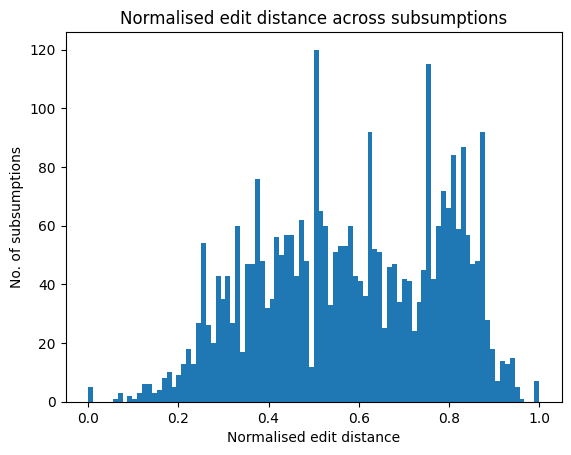

In [ ]:
plt.hist(sub_normalised, bins=len(sub_norm_distribution))
plt.xlabel("Normalised edit distance")
plt.ylabel("No. of subsumptions")
plt.title("Normalised edit distance across subsumptions")
print("Normalised:", sorted(sub_norm_distribution.items(), key=lambda x:x[0]))

{'whiskers': [<matplotlib.lines.Line2D at 0x7da6bdc9c1c0>,
 'caps': [<matplotlib.lines.Line2D at 0x7da6bdc9c700>,
 'boxes': [<matplotlib.lines.Line2D at 0x7da6bdc77ee0>],
 'medians': [<matplotlib.lines.Line2D at 0x7da6bdc9cc40>],
 'fliers': [<matplotlib.lines.Line2D at 0x7da6bdc9cee0>],
 'means': []}

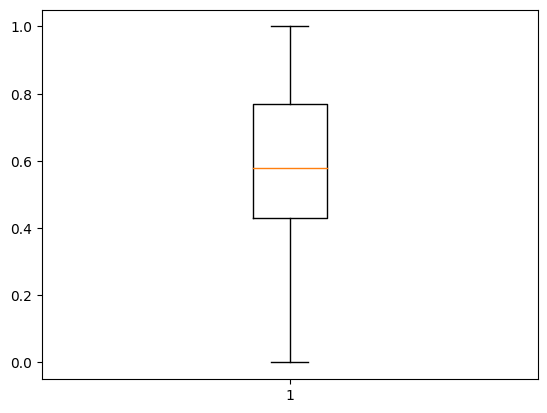

In [ ]:
plt.boxplot(sub_normalised)

In [ ]:
print("Subsumptions with distinct terms:\n")

sub_count = 0
for (source, target) in str_subsumptions.items():
  if editdistance.eval(source, target) / max(len(source), len(target)) > 0:
    sub_count += 1
    if sub_count % 100 == 0:
      print(f"{source} -> {target}")

print(f"\n{sub_count} out of {len(str_subsumptions)} ({(100 * sub_count/len(str_subsumptions)):.1f}%) are distinct")

Subsumptions with distinct terms:

b acute lymphoblastic leukemia with t(1;19)(q23;p13.3); tcf3-pbx1 -> b-lymphoblastic leukemia/lymphoma
acute myeloid leukemia without maturation -> acute myeloid leukemia
neurofibromatosis type 1 -> neurofibromatosis
galactocele -> breast cyst
disseminated intravascular coagulation in newborn -> disseminated intravascular coagulation
esophagitis -> esophageal disease
spinal muscular atrophy -> motor neuron disease
platelet disorder -> blood coagulation disease
giant papillary conjunctivitis -> papillary conjunctivitis
ehlers-danlos syndrome -> collagen disease
pediculosis pubis -> lice infestation
proctitis -> rectal disease
monkeypox -> viral infectious disease
laryngitis -> laryngeal disease
broad ligament mucinous adenocarcinoma -> uterine ligament adenocarcinoma
nut allergy -> food allergy
mesenchymal extraskeletal chondrosarcoma -> extraskeletal myxoid chondrosarcoma
myxosarcoma -> connective tissue cancer
angioleiomyoma -> vascular disease
gallb

In [ ]:
source_contained = np.array([1 if source in target else 0 for (source, target) in str_subsumptions.items()])
target_contained = np.array([1 if target in source else 0 for (source, target) in str_subsumptions.items()])

source_contained_distribution = Counter(source_contained)
target_contained_distribution = Counter(target_contained)

Source contained in 10 out of 3217 (0.3%)


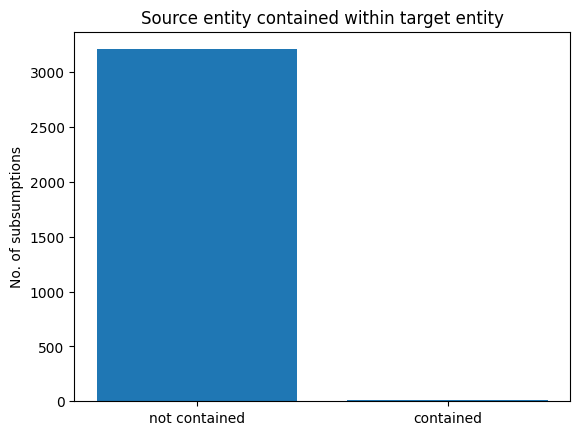

In [ ]:
plt.bar(["not contained", "contained"], [len(source_contained)-np.sum(source_contained), np.sum(source_contained)])
plt.ylabel("No. of subsumptions")
plt.title("Source entity contained within target entity")
print(f"Source contained in {source_contained_distribution[1]} out of {len(source_contained)} ({100*source_contained_distribution[1]/len(source_contained):.1f}%)")

Target contained in 788 out of 3217 (24.5%)


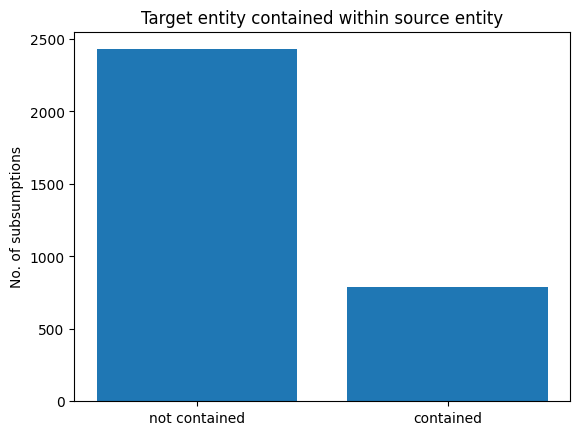

In [ ]:
plt.bar(["not contained", "contained"], [len(target_contained)-np.sum(target_contained), np.sum(target_contained)])
plt.ylabel("No. of subsumptions")
plt.title("Target entity contained within source entity")
print(f"Target contained in {target_contained_distribution[1]} out of {len(target_contained)} ({100*target_contained_distribution[1]/len(target_contained):.1f}%)")

## Negative mappings

In [ ]:
str_nsubsumptions = {ncit.get_term(source).name.lower() : doid.get_term(target[0]).name.lower() for (source, target) in neg_random_ncit2doid.items() if source in ncit.terms() and target[0] in doid.terms()}

nsub_distances = np.array([editdistance.eval(source, target) for (source, target) in str_nsubsumptions.items()])
nsub_lengths = np.array([max(len(source), len(target)) for (source, target) in str_nsubsumptions.items()])
nsub_normalised = np.round(nsub_distances / nsub_lengths, decimals=2)

nsub_dist_distribution = Counter(nsub_distances)
nsub_norm_distribution = Counter(nsub_normalised)

Distances: [(3, 1), (5, 1), (6, 3), (7, 5), (8, 16), (9, 20), (10, 35), (11, 56), (12, 75), (13, 100), (14, 112), (15, 113), (16, 135), (17, 159), (18, 174), (19, 197), (20, 164), (21, 174), (22, 160), (23, 171), (24, 140), (25, 132), (26, 126), (27, 119), (28, 113), (29, 91), (30, 80), (31, 58), (32, 54), (33, 47), (34, 50), (35, 47), (36, 29), (37, 33), (38, 23), (39, 16), (40, 22), (41, 18), (42, 9), (43, 13), (44, 16), (45, 11), (46, 9), (47, 5), (48, 8), (49, 11), (50, 4), (51, 6), (52, 4), (53, 7), (54, 3), (55, 2), (56, 4), (57, 6), (58, 2), (59, 5), (60, 3), (61, 3), (62, 1), (63, 3), (65, 1), (66, 1), (69, 1), (70, 2), (74, 1), (75, 1), (77, 2), (78, 1), (89, 1), (106, 1), (115, 1)]
Median: 22.0, Mean: 23.55, STD: 9.58


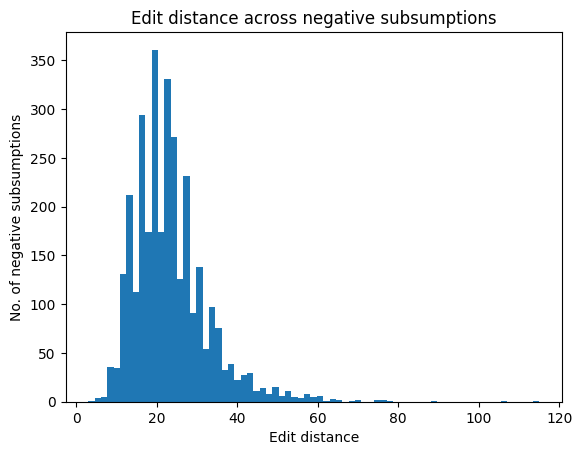

In [ ]:
plt.hist(nsub_distances, bins=len(nsub_dist_distribution))
plt.xlabel("Edit distance")
plt.ylabel("No. of negative subsumptions")
plt.title("Edit distance across negative subsumptions")
print("Distances:", sorted(nsub_dist_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(nsub_distances)}, Mean: {np.mean(nsub_distances):.2f}, STD: {np.std(nsub_distances):.2f}")

Normalised: [(0.15, 1), (0.38, 1), (0.39, 1), (0.4, 2), (0.41, 1), (0.44, 1), (0.46, 1), (0.47, 4), (0.48, 2), (0.49, 1), (0.5, 4), (0.52, 6), (0.53, 3), (0.54, 2), (0.55, 3), (0.56, 8), (0.57, 5), (0.58, 6), (0.59, 11), (0.6, 7), (0.61, 14), (0.62, 13), (0.63, 7), (0.64, 22), (0.65, 13), (0.66, 13), (0.67, 33), (0.68, 32), (0.69, 27), (0.7, 45), (0.71, 54), (0.72, 58), (0.73, 71), (0.74, 95), (0.75, 112), (0.76, 148), (0.77, 152), (0.78, 124), (0.79, 223), (0.8, 144), (0.81, 229), (0.82, 194), (0.83, 222), (0.84, 141), (0.85, 151), (0.86, 176), (0.87, 94), (0.88, 187), (0.89, 71), (0.9, 88), (0.91, 43), (0.92, 48), (0.93, 37), (0.94, 25), (0.95, 14), (0.96, 6), (1.0, 21)]
Median: 0.81, Mean: 0.80, STD: 0.08


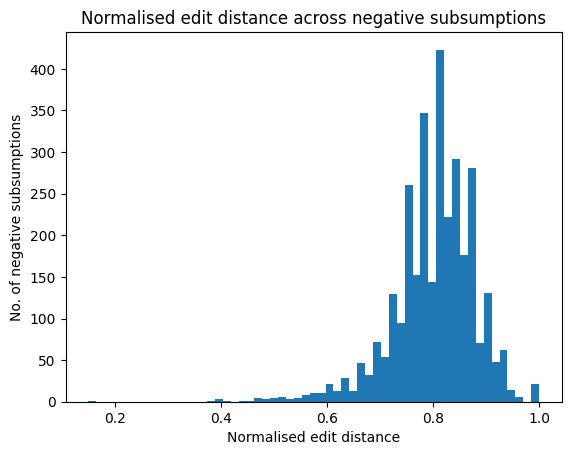

In [ ]:
plt.hist(nsub_normalised, bins=len(nsub_norm_distribution))
plt.xlabel("Normalised edit distance")
plt.ylabel("No. of negative subsumptions")
plt.title("Normalised edit distance across negative subsumptions")
print("Normalised:", sorted(nsub_norm_distribution.items(), key=lambda x:x[0]))
print(f"Median: {np.median(nsub_normalised)}, Mean: {np.mean(nsub_normalised):.2f}, STD: {np.std(nsub_normalised):.2f}")

{'whiskers': [<matplotlib.lines.Line2D at 0x7da6bd91e7d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7da6bd91ed10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7da6bd91e530>],
 'medians': [<matplotlib.lines.Line2D at 0x7da6bd91f250>],
 'fliers': [<matplotlib.lines.Line2D at 0x7da6bd91f4f0>],
 'means': []}

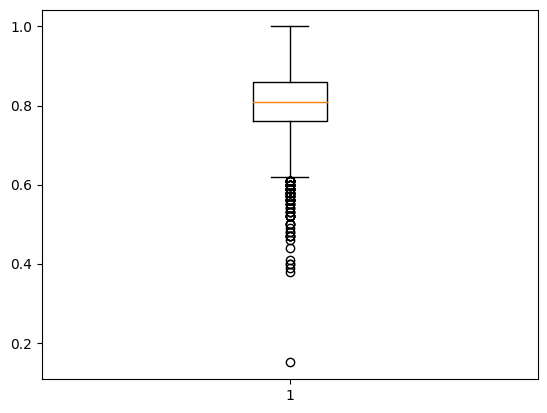

In [ ]:
plt.boxplot(nsub_normalised)

In [ ]:
print("Negative subsumptions with distinct terms:\n")

nsub_count = 0
for (source, target) in str_nsubsumptions.items():
  if editdistance.eval(source, target) / max(len(source), len(target)) > 0:
    nsub_count += 1
    if nsub_count % 100 == 0:
      print(f"{source} -> {target}")

print(f"\n{nsub_count} out of {len(str_nsubsumptions)} ({(100 * nsub_count/len(str_nsubsumptions)):.1f}%) are distinct")

Negative subsumptions with distinct terms:

b acute lymphoblastic leukemia with t(5;14)(q31.1;q32.3); il3-igh -> primary systemic mycosis
acute myeloid leukemia with minimal differentiation -> b-cell lymphoma
x-linked centronuclear myopathy -> salivary gland disease
mediastinal ganglioneuroblastoma -> primary bacterial infectious disease
polycythemia neonatorum -> uterine fibroid
creutzfeldt-jakob disease -> blindness
bronchopneumonia -> acute myeloid leukemia
nasal cavity disorder -> breast sarcoma
thrombophilia -> nerve plexus neoplasm
nesidioblastosis -> renal tubular transport disease
endometrial stromal nodule -> amino acid metabolic disorder
hepatobiliary neoplasm -> autonomic neuropathy
thymoma type b -> bile duct carcinoma
idiopathic granulomatous myositis -> supraglottis cancer
olfactory neuroblastoma -> urea cycle disorder
syndrome of apparent mineralocorticoid excess -> mitral valve disease
mesenchymal chondrosarcoma -> breast adenocarcinoma
vaginal adenosarcoma -> cognitive

In [ ]:
nsource_contained = np.array([1 if source in target else 0 for (source, target) in str_nsubsumptions.items()])
ntarget_contained = np.array([1 if target in source else 0 for (source, target) in str_nsubsumptions.items()])

nsource_contained_distribution = Counter(nsource_contained)
ntarget_contained_distribution = Counter(ntarget_contained)

Source contained in 0 out of 3217 (0.0%)


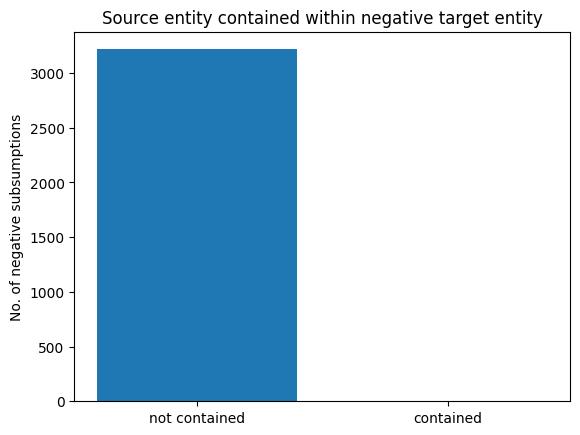

In [ ]:
plt.bar(["not contained", "contained"], [len(nsource_contained)-np.sum(nsource_contained), np.sum(nsource_contained)])
plt.ylabel("No. of negative subsumptions")
plt.title("Source entity contained within negative target entity")
print(f"Source contained in {nsource_contained_distribution[1]} out of {len(nsource_contained)} ({100*nsource_contained_distribution[1]/len(nsource_contained):.1f}%)")

Target contained in 6 out of 3217 (0.2%)


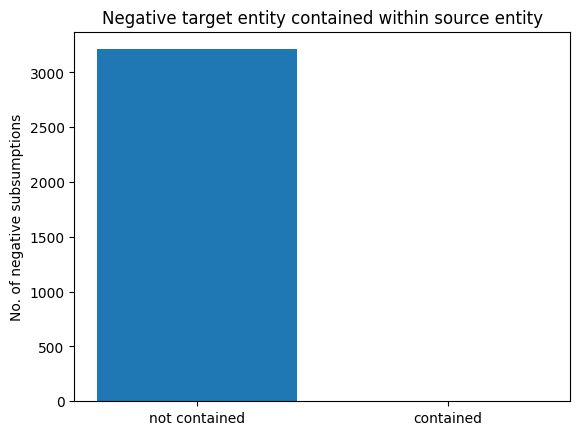

In [ ]:
plt.bar(["not contained", "contained"], [len(ntarget_contained)-np.sum(ntarget_contained), np.sum(ntarget_contained)])
plt.ylabel("No. of negative subsumptions")
plt.title("Negative target entity contained within source entity")
print(f"Target contained in {ntarget_contained_distribution[1]} out of {len(ntarget_contained)} ({100*ntarget_contained_distribution[1]/len(ntarget_contained):.1f}%)")